In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

In [3]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [4]:
import matplotlib.pyplot as plt

In [54]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [6]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

In [55]:
night_start = 0
path = "../neocp/neo/"
detection_window = 15
min_nights = 3
schedule_type = "actual"

# create a list of nights in the detection window and get schedule for them
night_list = list(range(night_start, night_start + detection_window))

if schedule_type == "predicted":
    full_schedule = scheduling.get_LSST_schedule(night=night_start, schedule_type=schedule_type)
else:
    full_schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1),
                                                 schedule_type=schedule_type)

# offset the schedule by one row and re-merge to get the previous night column
shifted = full_schedule.shift()
full_schedule["previousNight"] = shifted["night"]

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

file = 0
visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")

# get the objects from the night
obs_mask = np.logical_and(visit_file["night"] == night_start, visit_file["scores"] >= 65)
sorted_obs = visit_file[obs_mask].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs.index.unique()

# Main run

In [ ]:
%%time
probs, unique_objs = detection_probability.get_detection_probabilities(night_start=0, schedule_type="actual")

Everything is prepped and ready for probability calculations
0/155: 30.67, 00000EE, 0.747
1/155: 20.73, 00000CC, 0.000
2/155: 27.09, 0000240, 0.327
3/155: 30.46, 0000243, 0.734
4/155: 29.01, 000022D, 0.340
5/155: 31.34, 00008A3, 0.712
6/155: 19.96, 000095E, 0.000
7/155: 36.48, 0000966, 0.104
8/155: 33.84, 00009E5, 0.788
9/155: 35.01, 0000AE6, 0.811
10/155: 26.37, 0000AE9, 0.542
11/155: 27.37, 0000AFE, 0.460
12/155: 27.57, 0000C78, 0.211
13/155: 22.85, 0000D5E, 0.000
14/155: 30.60, 0000DBE, 0.694
15/155: 24.86, 0000E6C, 0.178
16/155: 23.54, 000031A, 0.030
17/155: 21.40, 000050F, 0.000
18/155: 19.23, 0000686, 0.000
19/155: 25.08, 000075D, 0.467
20/155: 28.05, 0000791, 0.000
21/155: 20.80, 0001796, 0.000
22/155: 29.27, 0001855, 0.538
23/155: 22.22, 00018A1, 0.000
24/155: 27.55, 0001914, 0.240
25/155: 28.24, 0001C31, 0.577
26/155: 26.89, 000121A, 0.568
27/155: 18.76, 0001270, 0.068
28/155: 27.66, 00012DC, 0.654
29/155: 35.27, 00013AB, 0.597
30/155: 30.06, 00013B3, 0.588
31/155: 26.13, 0001

In [24]:
np.save("probs_night0_actual_schedule.npy", probs)

In [11]:
findable_ids = np.load("neo_findable_first_10_25.npy", allow_pickle=True)
will_be_detected = np.isin(unique_objs, findable_ids)

In [12]:
threshold = 0.5
correct_detectable = len(probs[np.logical_and(probs >= threshold, will_be_detected)])
correct_undetectable = len(probs[np.logical_and(probs < threshold, np.logical_not(will_be_detected))])
incorrect_detectable = len(probs[np.logical_and(probs >= threshold, np.logical_not(will_be_detected))])
incorrect_undetectable = len(probs[np.logical_and(probs < threshold, will_be_detected)])


print(f"Of the {len(probs)} objects, we classified")
print(f"  {correct_detectable + correct_undetectable} correctly")
print(f"    {correct_detectable} were detectable")
print(f"    {correct_undetectable} were undetectable")
print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
print(f"    {incorrect_detectable} were detectable")
print(f"    {incorrect_undetectable} were undetectable")

Of the 196 objects, we classified
  152 correctly
    65 were detectable
    87 were undetectable
  44 incorrectly
    18 were detectable
    26 were undetectable


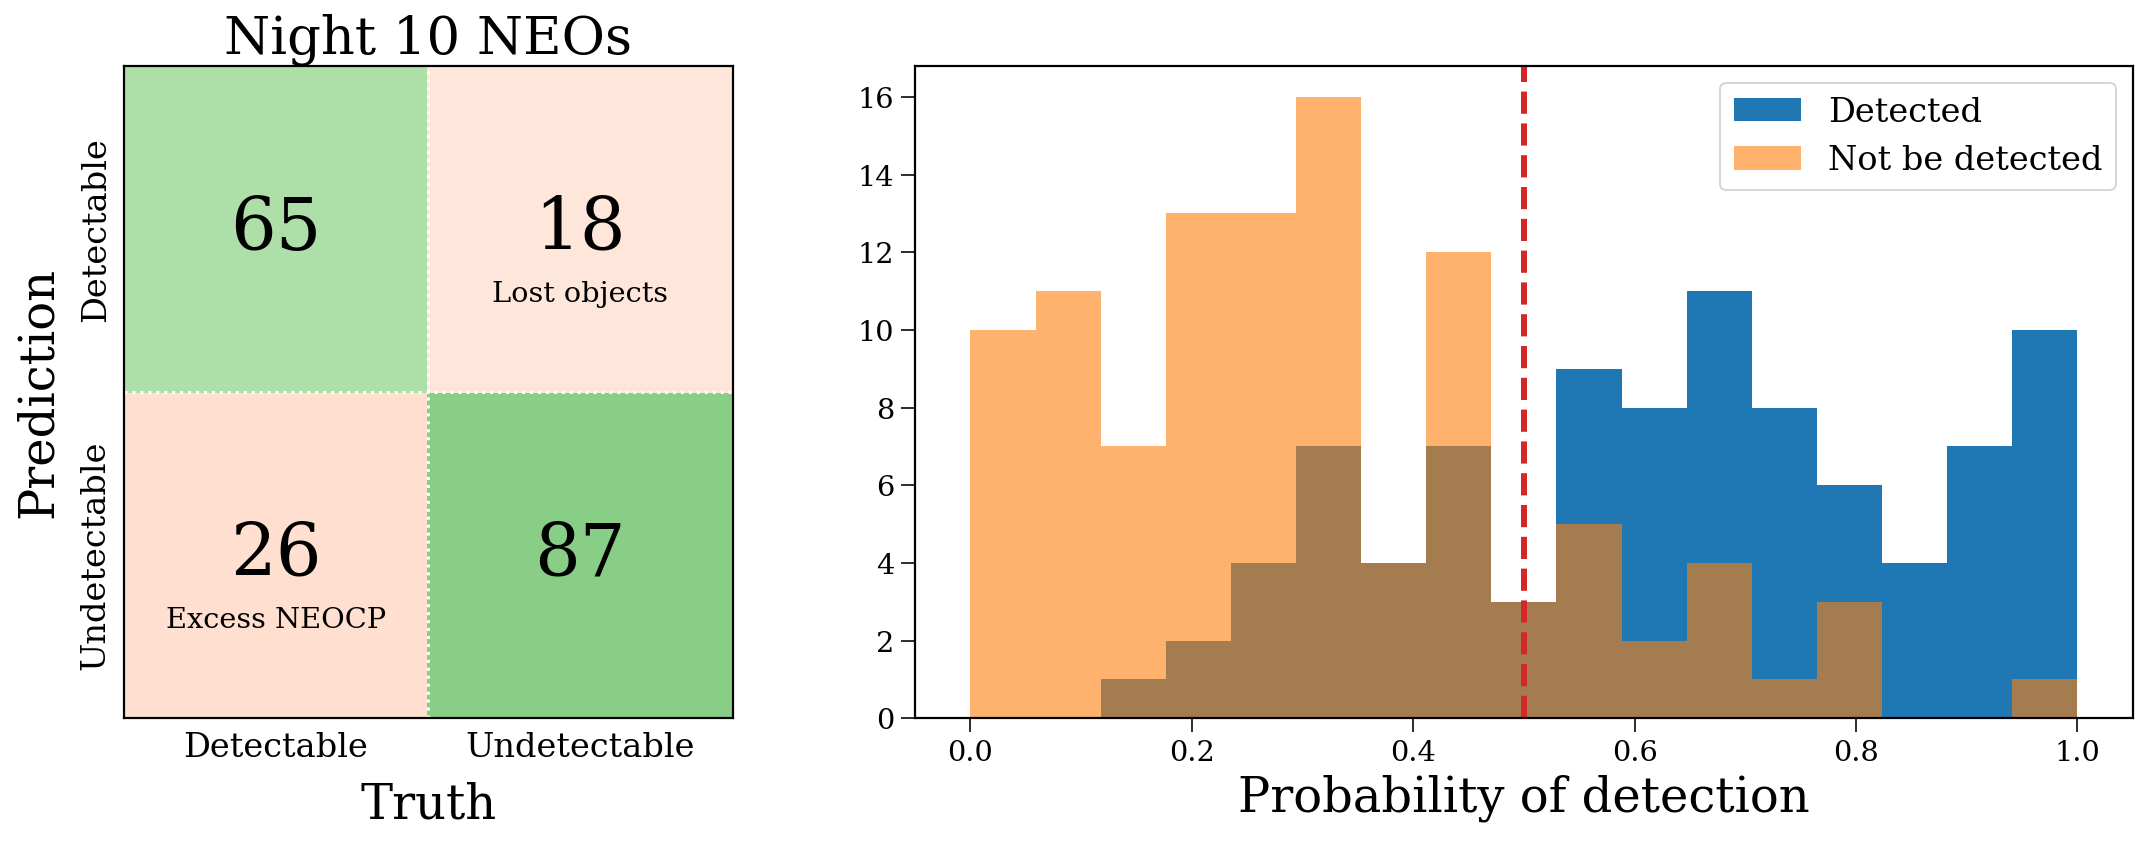

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 2]})

axes[0].set_title(f"Night {night_start} NEOs", fontsize=1.1*fs)

axes[0].axvline(0.5, color="white", linestyle="dotted")
axes[0].axhline(0.5, color="white", linestyle="dotted")

axes[0].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
axes[0].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

axes[0].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
axes[0].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

axes[0].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
axes[0].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
axes[0].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

axes[0].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(probs)))
axes[0].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(probs)))
axes[0].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(probs)))
axes[0].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(probs)))

axes[0].set_xlabel("\nTruth")
axes[0].set_ylabel("Prediction\n")

axes[0].set_xticks([])
axes[0].set_yticks([])

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)

bins = np.linspace(0, 1, 18)
axes[1].hist(probs[will_be_detected], label="Detected", bins=bins)
axes[1].hist(probs[np.logical_not(will_be_detected)], alpha=0.6, label="Not be detected", bins=bins)
axes[1].axvline(threshold, color="tab:red", linestyle="--", lw=3)

axes[1].set_xlabel("Probability of detection")
axes[1].legend(fontsize=0.7*fs)

plt.show()

### okay let's investigate some wrong ones

In [23]:
unique_objs[np.logical_and(probs < 0.3, will_be_detected)]

Index(['0006587', '0035981', '000F110'], dtype='object', name='hex_id')

In [223]:
unique_objs[np.logical_and(probs >= 0.65, np.logical_not(will_be_detected))]

Index(['00000A7', '000296A', '0029679', '000D5F1'], dtype='object', name='hex_id')

In [217]:
visit_file = pd.read_hdf(path + f"filtered_visit_scores_{file:03d}.h5")

In [221]:
visit_file.loc[hex_id]

,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores
hex_id,,,,,,,,,,,
0029679,S0000Jmga,10,59649.313389,173.261612,-44.821613,i,22.641466,22.005904,0.061383,3,100
0029679,S0000Jmga,10,59649.337293,173.240954,-44.873352,r,22.830508,18.745213,0.047774,3,100
0029679,S0000Jmga,10,59649.359496,173.221895,-44.921449,r,22.793511,24.205098,0.057604,3,100


In [44]:
import variant_orbits
import scheduling
import detection_probability
import magnitudes
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [50]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [41]:
hex_id = "0003F78"

In [45]:
%%time
prob, joined_table = detection_probability.probability_from_id(hex_id, sorted_obs,
                                                 np.logspace(-1, 1, 51) * u.AU,
                                                 np.linspace(-100, 100, 21) * u.km / u.s,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list)

CPU times: user 692 ms, sys: 5.06 s, total: 5.76 s
Wall time: 7.61 s


In [30]:
def filter_tracklets(df, min_obs=2, min_arc=1, max_time=90):
    init = SkyCoord(ra=df["RA_deg"].iloc[0], dec=df["Dec_deg"].iloc[0], unit="deg")
    final = SkyCoord(ra=df["RA_deg"].iloc[-1], dec=df["Dec_deg"].iloc[-1], unit="deg")

    return np.logical_and.reduce((len(df) >= min_obs,
                                  init.separation(final).to(u.arcsecond).value > min_arc,
                                  df["mjd_utc"].diff().min() * 1440 < max_time))

In [33]:
df = joined_table[np.logical_and(joined_table["observed"], np.logical_not(joined_table["observed"]))]

In [48]:
%%time
reachable_schedule = detection_probability.get_reachable_schedule(sorted_obs.loc[hex_id], first_visit_times,
                                                                  night_list, night_lengths, full_schedule)

CPU times: user 190 ms, sys: 2.45 s, total: 2.64 s
Wall time: 2.97 s


In [51]:
%%time
ephemerides, truth = detection_probability.first_last_pos_from_id(hex_id, sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1, 51) * u.AU,
                                                             np.linspace(-100, 100, 21) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

CPU times: user 1.31 s, sys: 10.9 s, total: 12.2 s
Wall time: 14.6 s


In [53]:
reload(detection_probability)
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(full_schedule), reachable_schedule=fixed(reachable_schedule),
         ephemerides=fixed(ephemerides), truth=fixed(truth), joined_table=fixed(joined_table),
         night=widgets.IntSlider(min=0, max=14, step=1, value=0, continuous_update=False),
         hex_id=fixed(hex_id),
         colour_by=widgets.Dropdown(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Dropdown(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         filter_mask=widgets.Dropdown(
            value='all',
            options=['all', 'u', 'g', 'r', 'i', 'z', 'y'],
            description='Filter:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
         show_mag_labels=widgets.ToggleButton(
            value=False,
            description='Show mag lims',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Whether to show limiting magnitudes for each field',
            icon='check'),
         fig=fixed(None), ax=fixed(None),show=fixed(True), cbar=fixed(True), ax_labels=fixed(True)
        )

interactive(children=(IntSlider(value=0, continuous_update=False, description='night', max=14), Dropdown(descr…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, ephemerides, joined_table, truth, night, hex_id, colour_by='distance', lims='full_schedule', field_radius=2.1, s=10, filter_mask='all', show_mag_labels=False, fig=None, ax=None, show=True, ax_labels=True, cbar=True)>

# Are particular orbits harder to predict (I guess yes)

Update: I guessed wrong

In [69]:
import thor

In [ ]:
true_params = s3m_cart[np.isin(s3m_cart["hex_id"], unique_objs)]

In [103]:
orbits_class = thor.Orbits(orbits=np.atleast_2d(np.concatenate(([true_params["x"], true_params["y"], true_params["z"]],
                                                                [true_params["vx"], true_params["vy"], true_params["vz"]]))).T,
                           epochs=Time(true_params["t_0"], format="mjd"))

In [83]:
orbits_class.keplerian = thor.kepler.convertOrbitalElements(orbits_class.cartesian,
                                                            "cartesian", "keplerian")

In [91]:
q = orbits_class.keplerian[:, 0] * (1 - orbits_class.keplerian[:, 1])

In [79]:
got_it_right = (probs > 0.5) == will_be_detected

In [88]:
colours = ["tab:green" if yup else "tab:red" for yup in got_it_right]

In [102]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


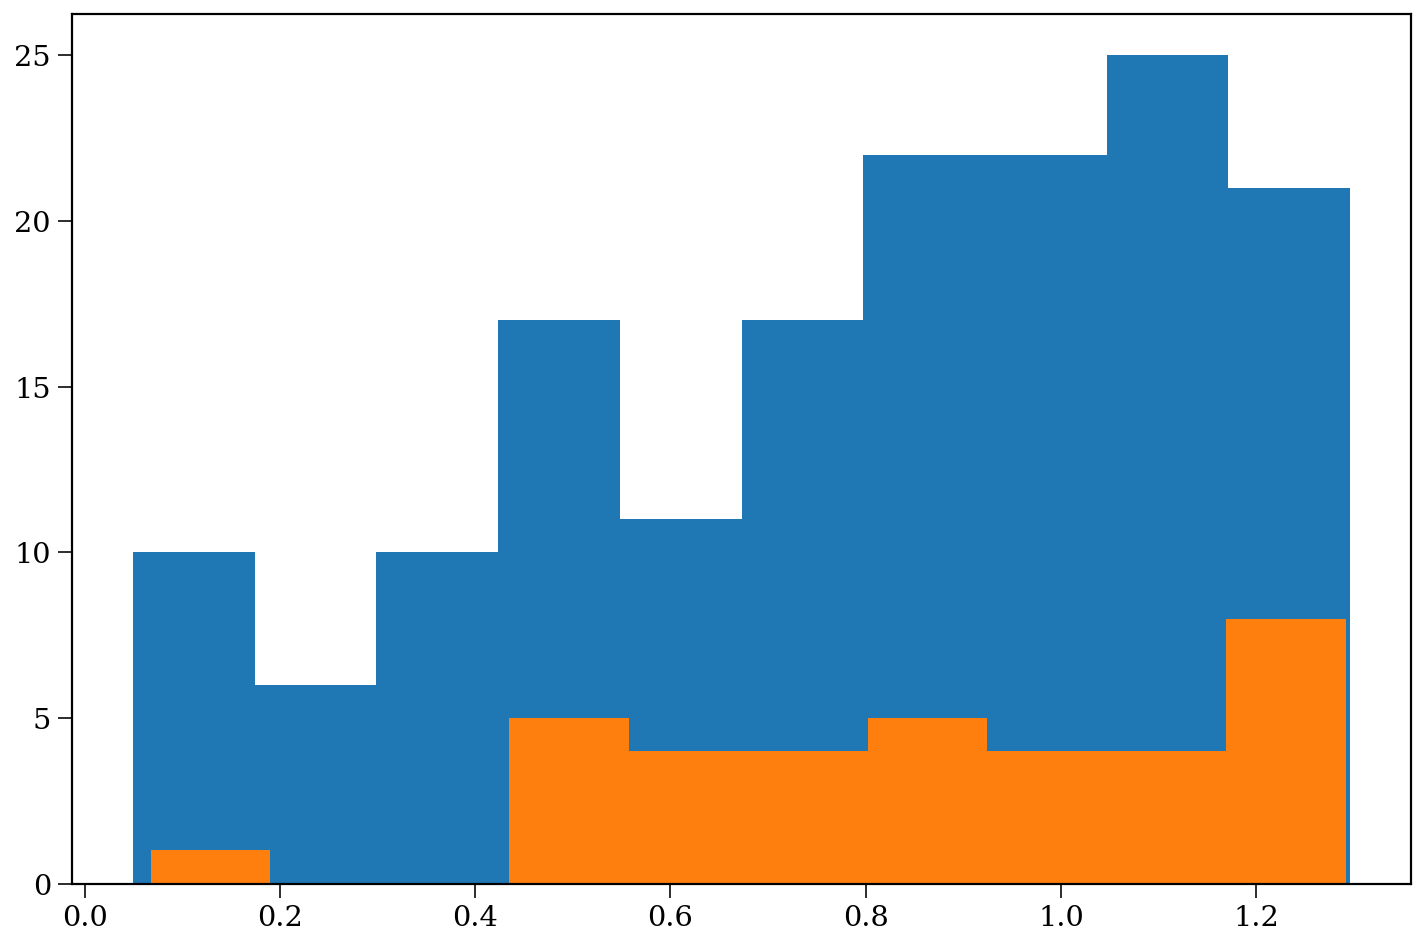

In [94]:
plt.hist(q[got_it_right])
plt.hist(q[np.logical_not(got_it_right)])
plt.show()

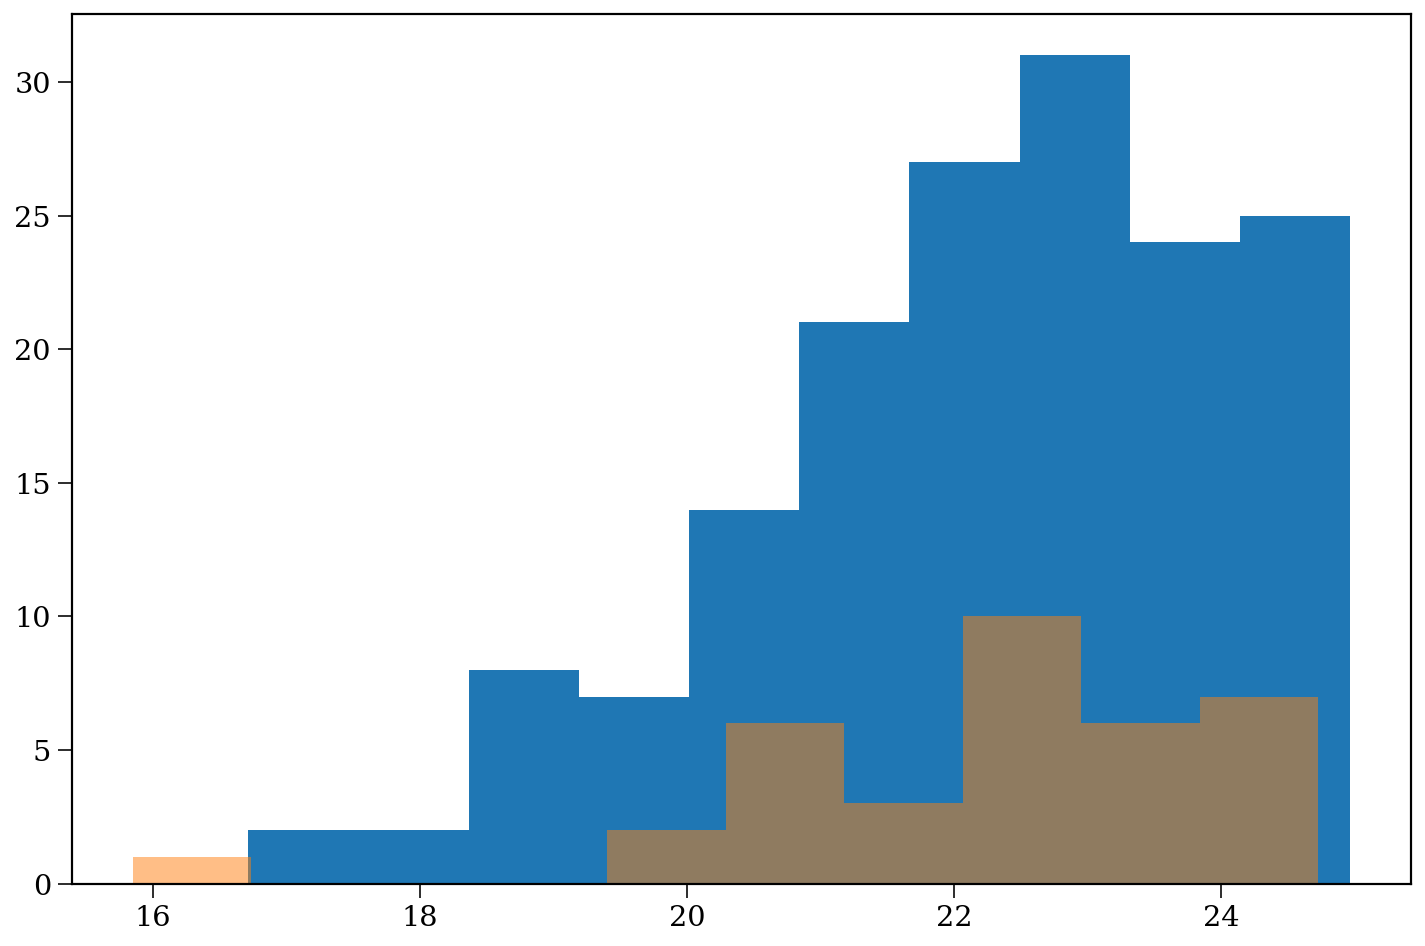

In [105]:
plt.hist(true_params["H"][got_it_right])
plt.hist(true_params["H"][np.logical_not(got_it_right)], alpha=0.5)
plt.show()

# Probability of each predicted detection based on orbit fraction

In [229]:
for i in range(10, 25):
    x = joined_table[joined_table["observed"] & (joined_table["night"] == i)]
    print(i)
    print(x.groupby("mjd_utc").count()["orbit_id"] / len(joined_table["orbit_id"].unique()) * 100)
    print()

10
mjd_utc
59649.295709    100.0
59649.296156    100.0
59649.320180    100.0
59649.320627    100.0
Name: orbit_id, dtype: float64

11
mjd_utc
59650.330174    100.000000
59650.351728     99.543379
Name: orbit_id, dtype: float64

12
mjd_utc
59651.250333    1.065449
59651.274791    0.913242
Name: orbit_id, dtype: float64

13
mjd_utc
59652.367719    77.625571
59652.376183     0.456621
59652.377078     6.392694
59652.378861    36.834094
59652.387323     0.608828
59652.388219     6.392694
Name: orbit_id, dtype: float64

14
mjd_utc
59653.244888    1.065449
59653.247818    3.500761
59653.268607    1.065449
59653.271480    3.348554
Name: orbit_id, dtype: float64

15
mjd_utc
59654.240757    8.980213
59654.241222    3.500761
59654.241678    0.608828
59654.242138    1.369863
59654.264676    9.132420
59654.265141    3.500761
59654.265598    0.608828
59654.266058    1.522070
Name: orbit_id, dtype: float64

16
mjd_utc
59655.262812     1.674277
59655.263260     2.435312
59655.263715    26.940639
59655

In [205]:
x = joined_table[joined_table["observed"] & (joined_table["night"] == 18)]
x.groupby("mjd_utc").count()["orbit_id"].values / len(joined_table["orbit_id"].unique()) * 100

array([ 0.15384615,  0.76923077, 36.        , 26.30769231,  8.30769231,
       19.38461538, 10.15384615,  2.61538462,  0.15384615,  0.76923077,
       36.30769231, 26.30769231,  8.30769231, 19.53846154, 10.30769231,
        2.46153846,  0.15384615,  0.76923077, 36.        , 26.30769231,
        8.        , 19.53846154, 10.46153846,  2.46153846,  0.15384615,
        0.76923077, 35.84615385, 26.30769231,  8.        , 19.38461538,
       10.76923077,  2.46153846,  0.76923077, 26.30769231,  8.        ,
       19.23076923, 35.84615385,  0.15384615,  0.76923077, 26.15384615,
        8.        , 19.38461538, 35.69230769,  0.15384615,  0.15384615,
        0.76923077, 35.69230769, 26.15384615,  0.15384615,  1.69230769,
       19.69230769, 10.61538462,  2.30769231,  0.15384615,  0.76923077,
       35.53846154, 26.15384615,  0.15384615,  1.84615385, 19.38461538,
       10.61538462,  2.30769231])